# Processing ``orderproducts.csv``

From our last notebook, we have to find a way to synthesize an order
with multiple products into an overall, fixed representation of
the order. In stricter words:



$Let \ two \ Orders:$

$O_i = [p_{i1},  p_{i2}, ... , p_{im}]; \ Oj=[p_{j1}, p_{j2}, ... , p_{jn}]$

$Where:$

$p_{i} = [id_{i}, val_{i}, unit_{i}]$

$And:$

$m \neq n => |o_{i}| \neq |o_{j}|$

$Find \ f(x):$

$|f(o_{i})| = |f(o_{j})|$

To find a good way of synthesizing, let's check our table again.

In [6]:
import numpy as np
import pandas as pd

In [7]:
order_products = pd.read_csv('./data/order_products.csv')
order_products

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN
...,...,...,...,...
198495,edd8fe4fd7d75de060cae811756603b0,e7f4a5ea6d480b7a1a7076fad543875e,3.0,UN
198496,70c0ff9c8533539b1c04e96398fef697,f506d0401b99c6c00d8792d38ce93aa1,6.0,UN
198497,dcf086aadb08ef7e695fadd723d881a7,c9970c5966ad6399d1c52aef34268699,1.0,UN
198498,f5f76f8fb58cdafe94b41fd836dfcec7,2cdd75fa252b3918918c662922b11b6e,3.0,UN


## Creating a popularity weight for products
Usually, there's a good chance that weight-based products require a special task
from the store, which would take more time than unit-based products. Therefore,
for each order, we can add the weights and units separately to quantify how big
is our order without losing two possible influences.

Another influence we may be losing with adding up weight and units is how
frequently a store is requested for the same product. For example 1KG of Chicken
could be easier to process than 1KG of Duck (if it ever exists). So before we do
anything, let's add a popularity coefficient for each product in our database.

Also it's important to note that we can use this because there's
no missing data, so imputation is not necessary!

In [8]:
# create a function that adds overall popularity of product_id in database
# calculated as how many products or weight is bought compared to others
def add_popularity(df, new_col):
    container = []  # this is where we save popularity
    popularity = dict()  # we will register products that already were visited

    total_uni = df['quantity'][df['buy_unit']=='UN'].sum()
    total_wei = df['quantity'][df['buy_unit']=='KG'].sum()

    for product, quant, unit in zip(df['product_id'], df['quantity'], df['buy_unit']):
        # first let's check if we already found product before
        if product in popularity:
            container.append(popularity[product] * quant)
        else:  # calculate product popularity and add to dict
            prod_quant = df['quantity'][df['product_id'] == product].sum()
            if unit == 'UN':
                prod_pop = prod_quant/total_uni
            else:  # unit is wei
                prod_pop = prod_quant/total_wei
            # add pop
            popularity[product] = prod_pop
            # add my weighted pop to container
            container.append(prod_pop * quant)
    # add new_col with weighted popularity
    df[new_col] = container

    return

In [9]:
# let's test weighted popularity!
add_popularity(order_products, 'weighted_popularity')
order_products

,order_id,product_id,quantity,buy_unit,weighted_popularity
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN,0.001244
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG,0.000288
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN,0.000653
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN,0.000331
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN,0.000012
...,...,...,...,...,...
198495,edd8fe4fd7d75de060cae811756603b0,e7f4a5ea6d480b7a1a7076fad543875e,3.0,UN,0.003585
198496,70c0ff9c8533539b1c04e96398fef697,f506d0401b99c6c00d8792d38ce93aa1,6.0,UN,0.013314
198497,dcf086aadb08ef7e695fadd723d881a7,c9970c5966ad6399d1c52aef34268699,1.0,UN,0.001726
198498,f5f76f8fb58cdafe94b41fd836dfcec7,2cdd75fa252b3918918c662922b11b6e,3.0,UN,0.001714


<AxesSubplot:ylabel='Frequency'>

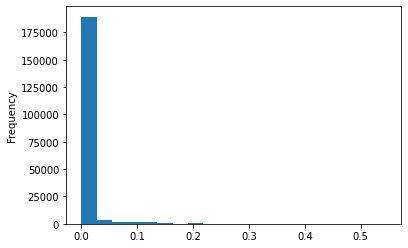

In [10]:
# how does it behave?
order_products['weighted_popularity'].plot.hist(bins=20)

Maybe it's better to use log(popularity) because of how exponentially small are it's values...

<AxesSubplot:ylabel='Frequency'>

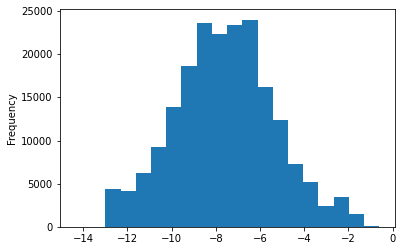

In [11]:
normalized_popularity = np.log(order_products['weighted_popularity'])
normalized_popularity.plot.hist(bins=20)

Now we can z-score it!

<AxesSubplot:ylabel='Frequency'>

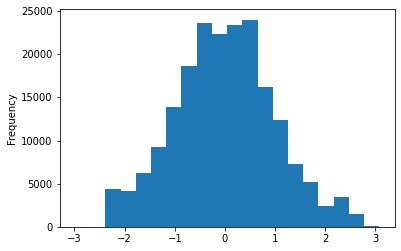

In [12]:
zscore_popularity = (normalized_popularity - normalized_popularity.mean())/normalized_popularity.std()
zscore_popularity.plot.hist(bins=20)

When we model, we may try using any of these two scales, raw popularity or zscored(log(popularity)).
How good each one performs depends on how well our model handles non-linearity.

Another interesting point is if we compute the normalization of popularity before or after adding
everything for the order_id. This makes sense because if we add a hundred
rare products we would like to impact overall popularity negatively which is
achieved by z-scoring popularity.

In [13]:
# change popularity for zscore(log(popularity))
order_products['weighted_popularity'] = zscore_popularity
order_products

,order_id,product_id,quantity,buy_unit,weighted_popularity
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN,0.394510
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG,-0.250192
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN,0.109980
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN,-0.189781
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN,-1.666715
...,...,...,...,...,...
198495,edd8fe4fd7d75de060cae811756603b0,e7f4a5ea6d480b7a1a7076fad543875e,3.0,UN,0.861048
198496,70c0ff9c8533539b1c04e96398fef697,f506d0401b99c6c00d8792d38ce93aa1,6.0,UN,1.439494
198497,dcf086aadb08ef7e695fadd723d881a7,c9970c5966ad6399d1c52aef34268699,1.0,UN,0.538726
198498,f5f76f8fb58cdafe94b41fd836dfcec7,2cdd75fa252b3918918c662922b11b6e,3.0,UN,0.535752


In [14]:
# create a function that transforms order_id into 4 values: {sum_uni, sum_wei, pop_uni, pop_wei}
# returns compressed version as a dictionary with order_id as the key
def compress_order_product(df):
    orders = dict()  # will contain sum_uni, sum_wei, pop_uni, pop_wei
    for order, quant, unit, pop in zip(df['order_id'], df['quantity'], df['buy_unit'], df['weighted_popularity']):
        is_wei = unit == 'KG'  # this will help us to locate values inside an order
        if not order in orders: # we need to create a new order in dict
            orders[order] = [0, 0.0, 0.0, 0.0]
        # add this product influence to dict
        orders[order][0 + is_wei] += quant
        orders[order][2 + is_wei] += pop
    return orders

In [15]:
# let's test this function!
orders_dict = compress_order_product(order_products)
# maybe convert to dataframe to analyze
compressed_orders = pd.DataFrame.from_dict(orders_dict, orient='index', columns=['sum_uni', 'sum_wei',
                                                                                 'pop_uni', 'pop_wei'])
compressed_orders

,sum_uni,sum_wei,pop_uni,pop_wei
47099653730fb1b76537fc10ad876255,44.0,12.700,3.121386,5.239230
689d8866915acf87e851c2591a23a82f,34.0,2.300,-3.448815,4.034073
f26d16bf6f38c9e31d0be877f4013a9e,35.0,0.240,-4.221307,1.475045
161ccc896835ab41761b0e726becb6b1,20.0,3.235,2.130173,5.720114
4713deca10bb5db98fae150b52d61fc0,116.0,0.300,-8.079476,0.455584
...,...,...,...,...
0ebd72696ae12532c87d9f3abcfb186e,1.0,0.000,-1.666715,0.000000
6927e22f7f1a09ebbcd3e23877962aba,1.0,0.000,-1.262733,0.000000
0ff3474dc3a636d3eb9dcc56ee3c7c8b,1.0,0.000,-2.277916,0.000000
52a5da88b7693ea11a9ec6423c302726,1.0,0.000,-1.972315,0.000000


<AxesSubplot:>

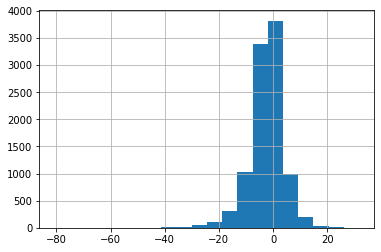

In [17]:
# let's check the distribution of summed popularity
compressed_orders['pop_uni'].hist(bins=20)

<AxesSubplot:>

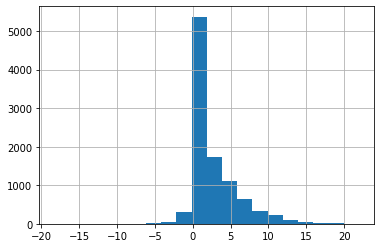

In [18]:
compressed_orders['pop_wei'].hist(bins=20)

<AxesSubplot:>

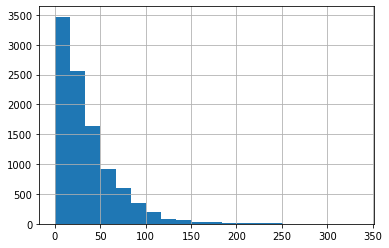

In [19]:
compressed_orders['sum_uni'].hist(bins=20)

<AxesSubplot:>

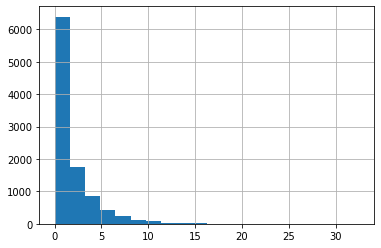

In [20]:
compressed_orders['sum_wei'].hist(bins=20)

## Conclusions
By using a compression of the order, consisting of the sum of weighted and unitary products, along with
a popularity scale of the products the bag contains, we can reflect two characteristics in the order:
* How "big" is the order.
* How "weird" is the order.

In case our compressed vector representing the order is "too compressed" we can make more feature
engineering in the order, for example creating sparse vectors representing each order in some way
and then reducing dimension. For now, we'll keep going.

In [21]:
# save the processed table
# before that we'll retake the indexing and add it as a column
compressed_orders['order_id'] = compressed_orders.index
compressed_orders.reset_index(inplace=True)

In [22]:
compressed_orders.drop('index', axis=1, inplace=True)
compressed_orders

,sum_uni,sum_wei,pop_uni,pop_wei,order_id
0,44.0,12.700,3.121386,5.239230,47099653730fb1b76537fc10ad876255
1,34.0,2.300,-3.448815,4.034073,689d8866915acf87e851c2591a23a82f
2,35.0,0.240,-4.221307,1.475045,f26d16bf6f38c9e31d0be877f4013a9e
3,20.0,3.235,2.130173,5.720114,161ccc896835ab41761b0e726becb6b1
4,116.0,0.300,-8.079476,0.455584,4713deca10bb5db98fae150b52d61fc0
...,...,...,...,...,...
9973,1.0,0.000,-1.666715,0.000000,0ebd72696ae12532c87d9f3abcfb186e
9974,1.0,0.000,-1.262733,0.000000,6927e22f7f1a09ebbcd3e23877962aba
9975,1.0,0.000,-2.277916,0.000000,0ff3474dc3a636d3eb9dcc56ee3c7c8b
9976,1.0,0.000,-1.972315,0.000000,52a5da88b7693ea11a9ec6423c302726


In [23]:
# now we save it
compressed_orders.to_csv('./data/order_products_processed.csv')